<a href="https://colab.research.google.com/github/samuel-haddad/MBAUSP/blob/main/logreg_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo Logit**

#### MBA Data Science & Analytics - USP & ESALQ
Trabalho de Conclusão de Curso - 02/2022 <br>
**Título:** Um estudo comparativo entre modelos Multinível, Logístico e XGBoost na detecção de fraudes ideológicas no setor financeiro. <br>
**Autor:** Samuel Haddad Simões Machado
<br>

## Bibliotecas

In [1]:
# pacotes básicos
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# preprocess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# modelagem
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings

# google libs & auth
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

## Dataset

In [2]:
# importar o dataset
sht1 = gc.open_by_key('14di6Prcuk4vAGsd43r60cnKcZh_M6ziQV8Ht7xcJ0b4')
df_sheet = sht1.get_worksheet(0)
df_data = df_sheet.get_all_records()

# criar o dataframe
df = pd.DataFrame(df_data)

# visualizar os dados
df.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var283,var284,var285,var286,var287,var288,var289,target,group,id
0,0.422658,0.030134,0.502699,-0.150856,-1.408410,0.008990,1,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,20,26
1,0.422658,0.662074,0.378098,-0.352544,-2.600380,0.549807,1,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,20,54
2,-0.277668,-0.024085,0.414200,0.068187,0.975530,0.549807,0,0,1,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,18,105
3,-0.243825,0.662074,-1.792512,1.268581,1.174192,-1.072644,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,18,154
4,0.086277,0.662074,0.608747,-0.352544,-0.613763,0.549807,0,1,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,27,182


## Treino, teste e validação

In [8]:
# remover a coluna de id
df_bronze = df.drop(['id'], axis=1)

# transformar a variável grupo em dummies
df_silver = pd.get_dummies(df_bronze, columns=['group'])

# extrair as variáveis explicativas e resposta
X, y = df_silver.drop(['target'], axis=1), df_silver['target']

# separar a base de treino
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=42)
 
# separar as bases de teste e validação
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# distribuição da variável resposta nas bases
y_train_dist = y_train.sum()/len(y_train)
y_test_dist = y_test.sum()/len(y_test)

# exibir a volumetria das bases
print('+', 25*'-','RESUMO', 25*'-','+')
print(f'X_test: {X_train.shape} | y_test: {len(y_test)} | y_val: {len(y_val)}')
print(f'Train dist: {round(y_train_dist*100, 2)}% | Test dist: {round(y_test_dist*100, 2)}%')
print('+', 58*'-', '+')

+ ------------------------- RESUMO ------------------------- +
X_test: (8903, 325) | y_test: 2968 | y_val: 2968
Train dist: 38.23% | Test dist: 38.71%
+ ---------------------------------------------------------- +


## Modelagem

In [ ]:
# construir o modelo com configuração padrão
model = LogisticRegression(max_iter=100000)

# treinar o modelo
model.fit(X_train, y_train)

# acurácia de treino
acuracy_train = model.score(X_train, y_train)


#---------- TESTE ----------#

# previsão - teste
y_pred_test = model.predict(X_test)

# extrair as métricas - test
acuracy_test = (metrics.accuracy_score(y_test, y_pred_test)*100).round(2)
precision_test = (metrics.precision_score(y_test, y_pred_test)*100).round(2)
recall_test = (metrics.recall_score(y_test, y_pred_test)*100).round(2)
aucroc_test = (roc_auc_score(y_test, model.predict_proba(X_test)[:,1])*100).round(2)
f1_score_test = (f1_score(y_test, y_pred_test)*100).round(2)
logloss_test = (metrics.log_loss(y_test, model.predict_proba(X_test), normalize=True))

#---------- TUNNING ----------#

warnings.filterwarnings('ignore')

# grid de parâmetros
parameters = {'penalty' : ['l1','l2']
              ,'C' : np.logspace(-3,3,7)
              ,'solver' : ['newton-cg', 'lbfgs', 'liblinear']
              }


# grid search
logreg = LogisticRegression()
clf = GridSearchCV(logreg
                   ,param_grid = parameters
                   ,scoring = 'roc_auc'
                   ,cv=10
                   )

clf.fit(X_train, y_train)

#---------- VALIDAÇÃO ----------#

# construir o modelo com parâmetros otimizados
model = LogisticRegression(**clf.best_estimator_.get_params())

# treinar o modelo
model.fit(X_train, y_train)

# previsão - validação
y_pred = model.predict(X_val)

# extrair as probabilidades
yhat = model.predict_proba(X_val)[:, 1]

# extrair as métricas - validação
acuracy_val = (metrics.accuracy_score(y_val, y_pred)*100).round(2)
precision_val = (metrics.precision_score(y_val, y_pred)*100).round(2)
recall_val = (metrics.recall_score(y_val, y_pred)*100).round(2)
aucroc_val = (roc_auc_score(y_val, yhat)*100).round(2)
f1_score_val = (f1_score(y_val, y_pred)*100).round(2)
logloss_val = (metrics.log_loss(y_val, yhat, normalize=True))

# criar o dataframe comparativo
columns= ['amostra', 'acuracia', 'precisao', 'recall', 'auc_roc', 'f1_score', 'logloss(normalizada)']
data = [('teste', acuracy_test, precision_test, recall_test, aucroc_test, f1_score_test, logloss_test)
        ,('validacao', acuracy_val, precision_val, recall_val, aucroc_val, f1_score_val, logloss_val)
        ]
df_metrics = pd.DataFrame(data=data, columns=columns)

# visualizar resultados do grid search
print('+', 18*'-','RESULTADO GRID SEARCH', 18*'-','+')
print(clf.best_params_)
print('+', 59*'-', '+')

# visualizar tabela comparativa
df_metrics

+ ------------------ RESULTADO GRID SEARCH ------------------ +
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
+ ----------------------------------------------------------- +


,amostra,acuracia,precisao,recall,auc_roc,f1_score,logloss(normalizada)
0,teste,72.51,68.00,54.74,77.93,60.66,0.545802
1,validacao,73.92,69.19,57.23,79.20,62.64,0.531232


## Gráficos

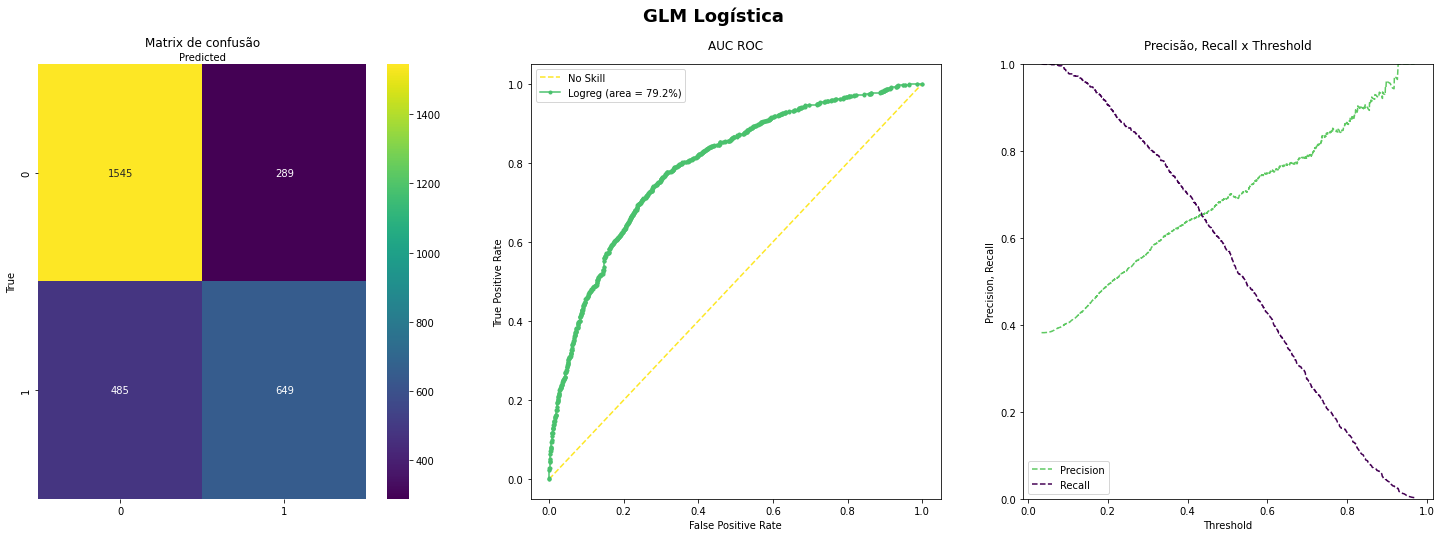

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), gridspec_kw=({'hspace':0.5}))
fig.suptitle('GLM Logística', fontsize=18, weight='semibold', y=0.98)
pad = 15

#---------- matriz de confusão ----------#
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
plt.subplot(1, 3, 1)

labels = [0, 1]
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# criar o heatmap
ax = sns.heatmap(data=pd.DataFrame(cnf_matrix), annot=True, cmap="viridis", fmt='g')
ax.xaxis.set_label_position("top")
ax.set_title('Matrix de confusão')
plt.ylabel('True')
plt.xlabel('Predicted');

#---------- auc roc ----------#
fpr, tpr, thresholds = roc_curve(y_val, yhat)

# plot da curva roc
plt.subplot(1, 3, 2)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725')
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', label='Logreg (area = {}%)'.format(aucroc_val))

# axis labels
plt.title('AUC ROC', pad=pad)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

#---------- precisão, recall x threshold ----------#
precision, recall, thresholds = precision_recall_curve(y_val, yhat) 

plt.subplot(1, 3, 3)
plt.title('Precisão, Recall x Threshold', fontsize=12, pad=pad)
plt.plot(thresholds, precision[: -1], "b--", label="Precision", color='#5ec962')
plt.plot(thresholds, recall[: -1], "r--", label="Recall", color='#440154')
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1]);